In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import fitsio
import glob
import scipy

import numpy as np
import healpy as hp
import xlens
import treecorr
import astropy.io.ascii as pyascii
import numpy.lib.recfunctions as rfn
from lsst.geom import degrees

from lsst.daf.butler import Butler
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

import lsst.afw.image as afwImage
from astropy.visualization import ZScaleInterval
from xlens.process_pipe.anacal_detect import (
    AnacalDetectPipe, AnacalDetectPipeConfig
)

In [14]:
if False:
    NSIDE = 1024
    mask = hp.read_map("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/fdfc_hp_window_premask.fits", nest=True, dtype=bool)
    data_all = []
    for ifield in [1, 2, 3, 4]:
        print(ifield)
        fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/gaia/%d.fits" % ifield
        data = fitsio.read(fname)
        ra = data['ra']
        dec = data['dec']
        theta = np.deg2rad(90.0 - dec)
        phi = np.deg2rad(ra)
        pix = hp.ang2pix(NSIDE, theta, phi, nest=True)
        mm = mask[pix]
        data = data[mm]
        print(np.min(data["ra"]), np.max(data["ra"]))
        print(np.min(data["dec"]), np.max(data["dec"]))
        data_all.append(data)
    data_all = rfn.stack_arrays(data_all, usemask=False)
    fitsio.write("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/gaia/stars.fits", data_all)

In [15]:
if False:
    NSIDE = 1024
    mask = hp.read_map("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/fdfc_hp_window.fits", nest=True, dtype=bool)
    data_all = []
    for ifield in ["a", "stars"]:
        fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/gaia/%s.fits" % ifield
        data = fitsio.read(fname)
        ra = data['ra']
        dec = data['dec']
        theta = np.deg2rad(90.0 - dec)
        phi = np.deg2rad(ra)
        pix = hp.ang2pix(NSIDE, theta, phi, nest=True)
        mm = mask[pix]
        data = data[mm]
        data_all.append(data)
    data_all = rfn.stack_arrays(data_all, usemask=False)
    pyfits.writeto("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/gaia/stars.fits", data_all, overwrite=True)

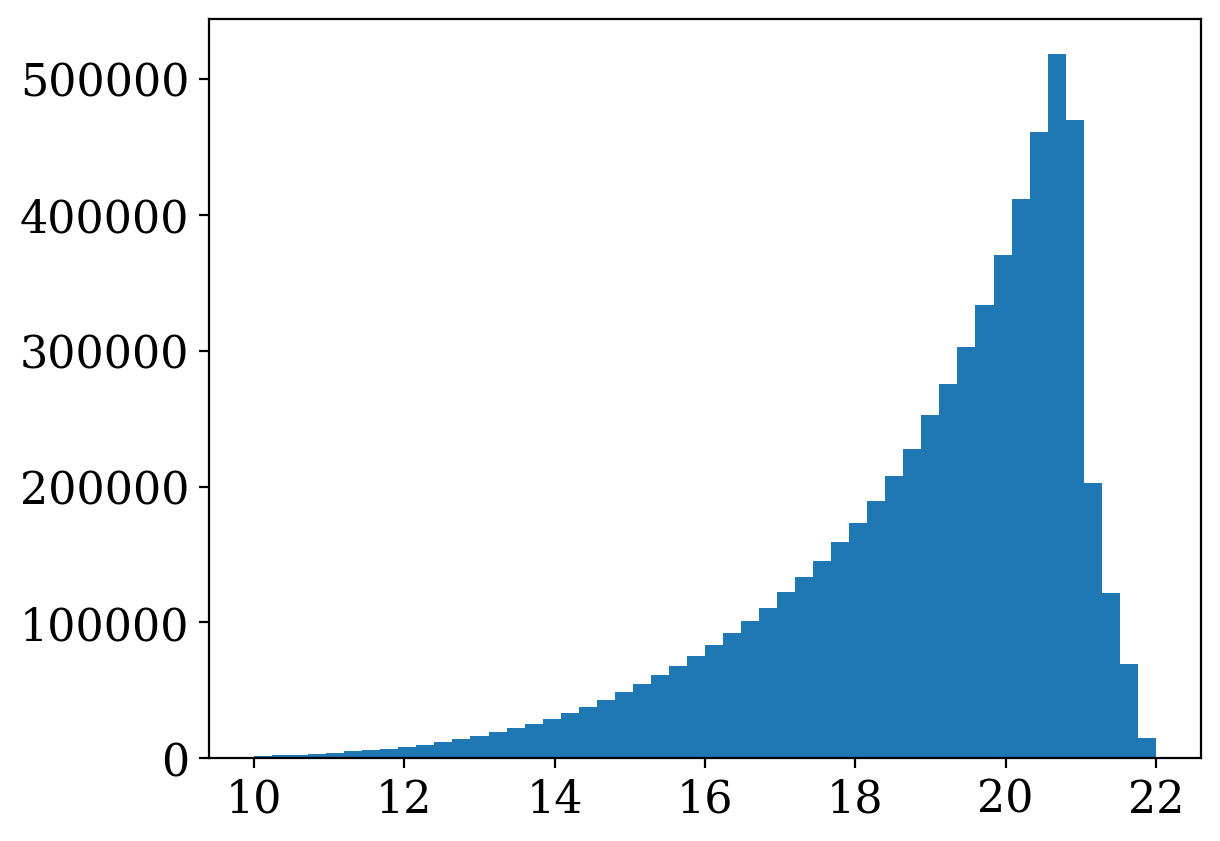

In [16]:
stars = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/gaia/stars.fits")
_ = plt.hist(stars["g_mag"], bins=50, range=(10, 22))

In [17]:
# Create x, y, yerr for all 8 plots
x_data = []
y_data = []
y_errs = []

def compute_xy(data_subset):
    arr = np.average(data_subset, axis=0)
    x  = arr[0]
    y1 = arr[1] / arr[3]
    y2 = arr[2] / arr[3]
    return x, y1, y2

for ff in ["gaia_bright", "gaia_median", "gaia_faint"]:
    data = fitsio.read(f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal_v2/tests/NG_{ff}.fits")
    # get the “nominal” values
    x, y1, y2 = compute_xy(data)
    
    # ---- bootstrap parameters ----
    nboot = 2000                      # number of bootstrap samples
    nreal = data.shape[0]             # how many realizations you have
    # pre-allocate arrays to hold each trial
    y1_boot = np.empty((nboot, y1.size))
    y2_boot = np.empty((nboot, y2.size))
    
    # ---- run the bootstrap ----
    for i in range(nboot):
        # sample `nreal` indices with replacement
        idx = np.random.choice(nreal, size=nreal, replace=True)
        # compute ratios on that resampled set
        _, y1_i, y2_i = compute_xy(data[idx])
        y1_boot[i] = y1_i
        y2_boot[i] = y2_i
    
    # ---- compute the 1-σ errors ----
    y1_err = np.std(y1_boot, axis=0)
    y2_err = np.std(y2_boot, axis=0)

    x_data.extend([x, x])
    y_data.extend([y1, y2])
    y_errs.extend([y1_err, y2_err])

/gpfs02/work/xiangchong.li/work/tmp/ipykernel_29267/772316754.py:9: RuntimeWarning: invalid value encountered in divide
  y1 = arr[1] / arr[3]
/gpfs02/work/xiangchong.li/work/tmp/ipykernel_29267/772316754.py:10: RuntimeWarning: invalid value encountered in divide
  y2 = arr[2] / arr[3]


12
13
15
[            nan             nan             nan -1.41007661e-03
 -1.78622227e-04  1.46759554e-04 -2.13972321e-04 -1.25625913e-04
  9.59141829e-05  5.47645930e-05  1.99632374e-05 -3.33596638e-05
 -1.75417440e-06  1.96175311e-05  4.80345641e-06 -1.67712319e-05
 -5.89936892e-06 -1.14589911e-05 -1.24428921e-05 -2.46285786e-05]
265.78860095624134
[            nan             nan  2.10238313e-04 -7.11522849e-05
  3.30574757e-05 -1.59643089e-04  7.86225347e-06  3.03957716e-05
 -4.61314542e-06 -1.32015216e-05 -1.66009297e-05 -6.49613407e-06
 -3.44140956e-06  7.07431481e-06  3.10855727e-07 -3.94495099e-06
 -1.39588888e-06 -7.69003599e-06 -1.36889168e-05 -2.40641776e-05]
184.7643704341444
[ 4.81834968e-05  1.29233478e-04  1.84688876e-05 -1.07650250e-04
  2.27873075e-05 -5.00253281e-05 -1.73600958e-05  3.59613581e-05
 -1.06307983e-05 -4.59971527e-06  1.13774511e-05 -6.80710817e-06
  2.37013683e-06 -7.92053291e-07  4.90468424e-07 -1.04864736e-06
 -3.58991453e-06 -1.10600936e-05 -1.738155

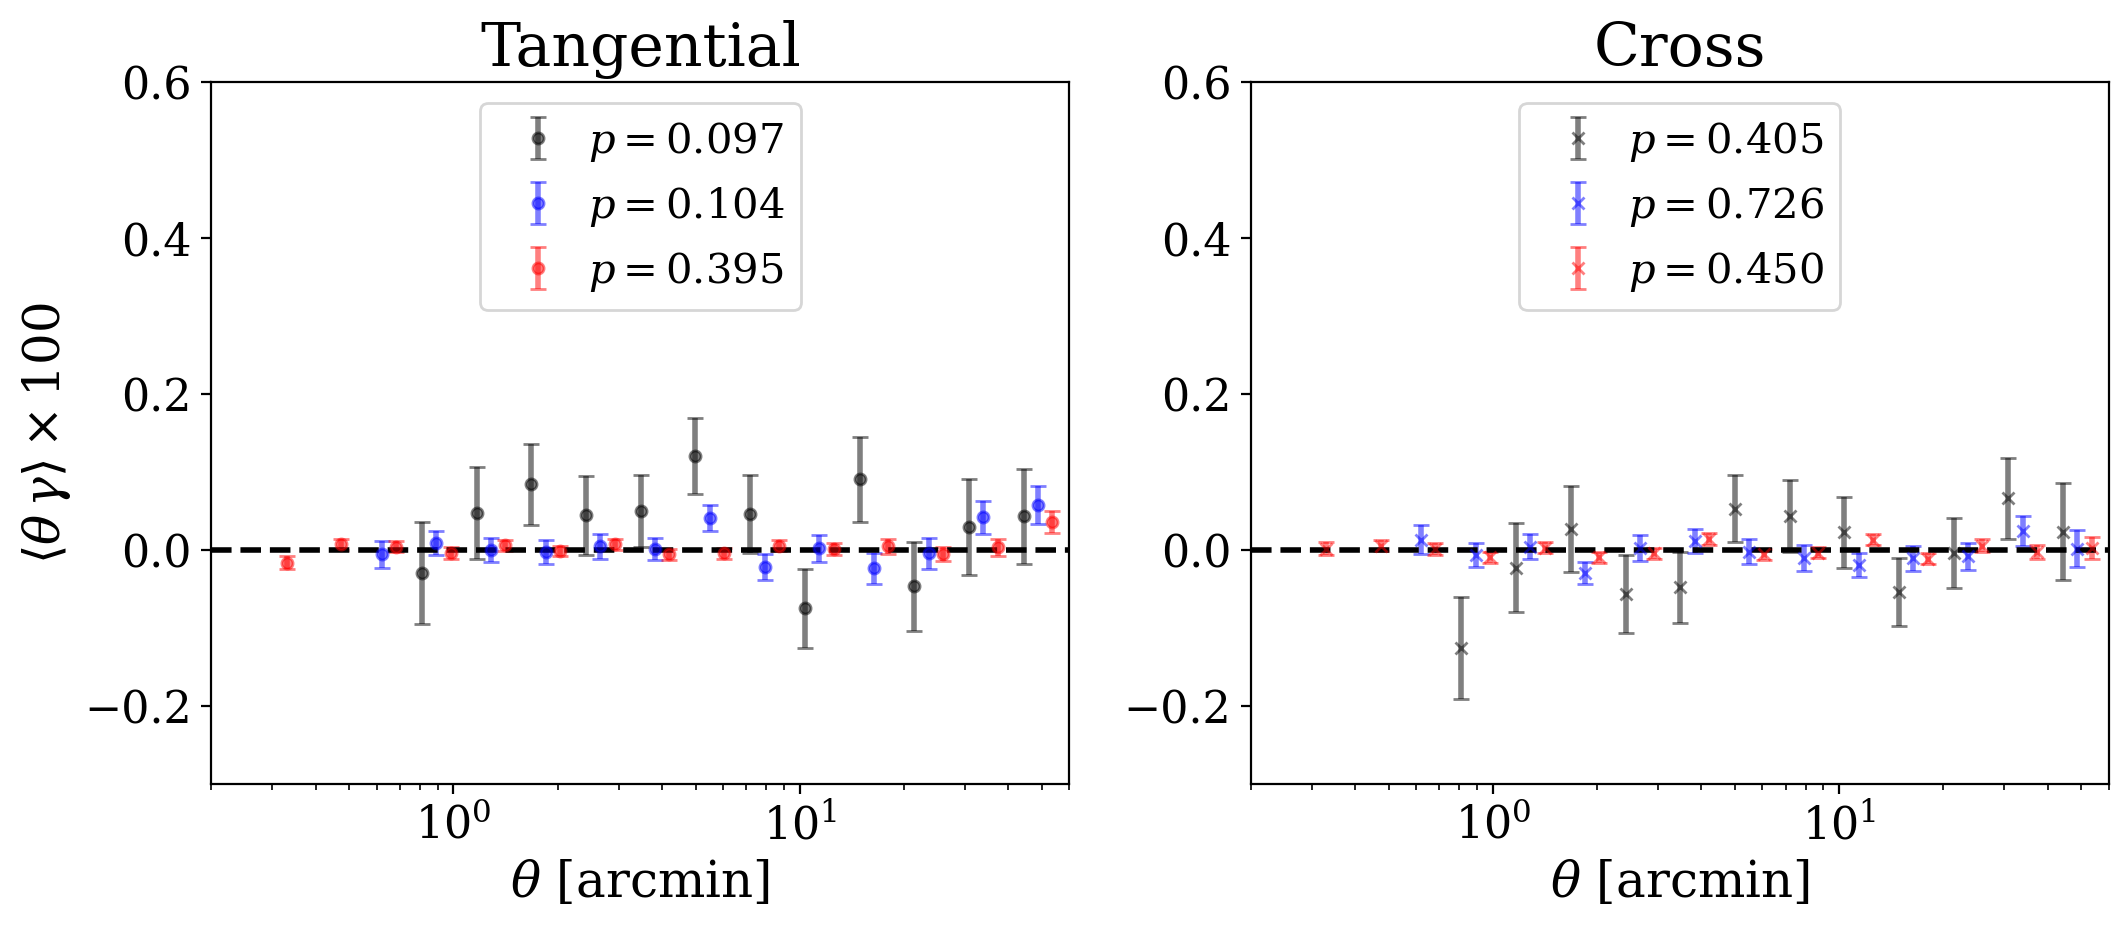

In [18]:
multiply = 100
plt.close()

colors = ["black", "blue", "red"]
rr = [1.0 / 1.10, 1.00, 1.10]

_, axes = plt.subplots(1, 2, figsize=(11, 5))
ax = axes[0]
iend = -5
for i in [0, 2, 4]:
    if i == 0:
        istart = 3
    elif i==2:
        istart = 2
    else:
        istart = 0
    chi2 = np.sum((y_data[i][istart:iend] / y_errs[i][istart:iend]) ** 2.0)
    df = len(y_data[i][istart:iend])
    pv = scipy.stats.chi2.sf(chi2, df)
    ax.errorbar(
        x_data[i] * rr[i//2], 
        y_data[i] * x_data[i] * multiply, 
        y_errs[i] * x_data[i] * multiply,
        fmt='o', ms=4, capsize=3, linestyle='', alpha=0.5, 
        color=colors[i // 2],
        label=r"$p=%.3f$" % (pv),
    )
    print(df)

ax.set_xscale('log')
ax.legend(fontsize=15, loc="upper center", handletextpad=0.2)
ax.axhline(0.0, ls='--', color='black')
ax.set_title("Tangential")
ax.set_xlabel(r"$\theta\ \mathrm{[arcmin]}$")
ax.set_ylabel(r"$\langle \theta\,\gamma \rangle \times 100$")
ax.set_xlim(0.2, 60)
ax.set_ylim(-0.3, 0.6)

ax = axes[1]
for i in [1, 3, 5]:
    if i == 1:
        istart = 3
    elif i==3:
        istart = 2
    else:
        istart = 0
    chi2 = np.sum((y_data[i][istart:iend] / y_errs[i][istart:iend]) ** 2.0)
    df = len(y_data[i][istart:iend])
    pv = scipy.stats.chi2.sf(chi2, df)
    ax.errorbar(
        x_data[i] * rr[i//2], 
        y_data[i] * x_data[i] * multiply, 
        y_errs[i] * x_data[i] * multiply,
        fmt='x', ms=4, capsize=3, linestyle='', alpha=0.5,
        color=colors[i // 2],
        label=r"$p =%.3f$" % (pv),
    )
    print(y_data[i])
    dlog = np.log(x_data[0][1])  - np.log(x_data[0][0])
    x_mins = np.exp(np.log(x_data[0]) - dlog / 2)
    print(x_mins[istart] * 60 / 0.168)
ax.set_xscale('log')
ax.legend(fontsize=15, loc="upper center", handletextpad=0.2)
ax.set_xlim(0.2, 60)
ax.set_ylim(-0.3, 0.6)
ax.axhline(0.0, ls='--', color='black')
ax.set_title("Cross")
ax.set_xlabel(r"$\theta\ \mathrm{[arcmin]}$")

plt.tight_layout()
plt.show()

In [7]:
x_data[0] - dlog / 2

array([1.18036600e-01, 2.49527519e-01, 4.38680802e-01, 7.10782975e-01,
       1.10220939e+00, 1.66528700e+00, 2.47528955e+00, 3.64050036e+00,
       5.31668799e+00, 7.72792975e+00, 1.11965670e+01, 1.61862965e+01,
       2.33641589e+01, 3.36897104e+01, 4.85432986e+01, 6.99105915e+01,
       1.00648027e+02, 1.44864669e+02, 2.08471517e+02, 2.99971708e+02])

In [8]:
0.35 * 0.35

0.12249999999999998

In [9]:
np.exp(np.log(x_data[0]) - dlog / 2) * 60 / 0.168

array([8.92857143e+01, 1.28439942e+02, 1.84764370e+02, 2.65788601e+02,
       3.82344173e+02, 5.50012551e+02, 7.91208100e+02, 1.13817450e+03,
       1.63729515e+03, 2.35529385e+03, 3.38815464e+03, 4.87395312e+03,
       7.01131489e+03, 1.00859683e+04, 1.45089412e+04, 2.08715089e+04,
       3.00242364e+04, 4.31906854e+04, 6.21309823e+04, 8.93771176e+04])

In [10]:
# Set up the configuration
config = RingsSkyMapConfig()
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0 / 60  # degrees
config.pixelScale = 0.168  # arcsec/pixel
skymap = RingsSkyMap(config)

In [11]:
if False:
    import astropy.io.fits as pyfits
    stars = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/gaia/stars.fits")
    stars = stars[stars["g_mag"] <= 14]
    mag = stars["g_mag"]
    conds  = [mag <= 11, (mag > 11) & (mag <= 14)]
    choices = [266.0, 185.0]
    tract_ids = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_id.fits")
    for tract_id in tract_ids:
        r = np.select(conds, choices, default=180)
        tract_info = skymap[tract_id]
        wcs = tract_info.getWcs()
        x, y = wcs.skyToPixelArray(
            ra=stars["ra"], 
            dec=stars["dec"],
            degrees=True,
        )
        bbox = tract_info.bbox
        msk = (
            (x > bbox.beginX - 500) & 
            (x < bbox.endX + 500) & 
            (y > bbox.beginY - 500) & 
            (y < bbox.endY + 500)
        )
        sub = stars[msk]
        x = x[msk]
        y = y[msk]
        r = r[msk]
        # Append fields
        sub = rfn.append_fields(
            sub,
            names=['x', 'y', 'r'],
            data=[x, y, r],
            dtypes=['f4', 'f4', 'f4'],
            usemask=False,
        )
        print(tract_id, len(sub), sub.dtype.names)
        pyfits.writeto("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/gaia/tracts/%d.fits" % tract_id, sub, overwrite=True)

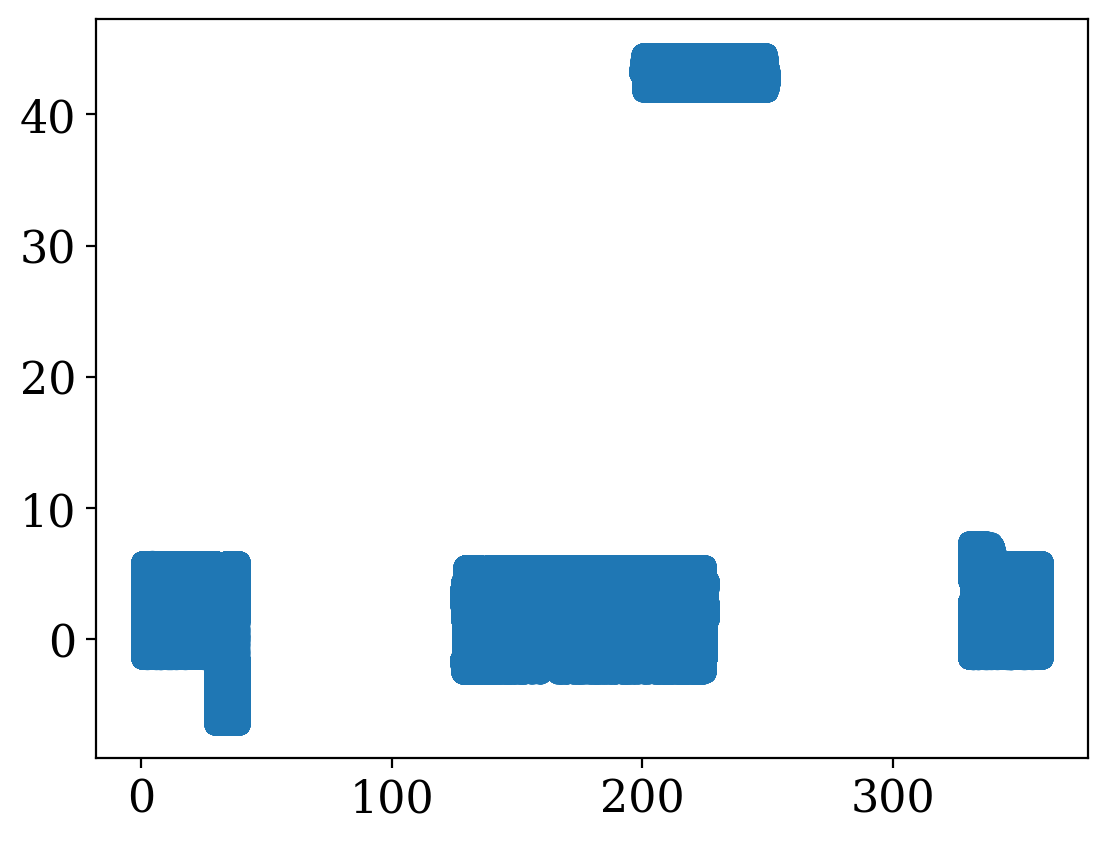

In [12]:
plt.scatter(stars["ra"], stars["dec"])

In [3]:
tp_list =fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_fdfc_v1_final.fits")
data = fitsio.read(f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal2/NG_gaia_bright.fits")
tracts_id=fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_id.fits")
tracts_id[data[:,3,0] > 0.1]

array([9563, 9720], dtype=int32)

In [4]:
patch_db = tp_list[tp_list["tract"] == 9720]["patch"]
patch_x = patch_db // 100
patch_y = patch_db % 100
patch_ids = patch_x + patch_y * 9
patch_ids = np.sort(patch_ids)

20


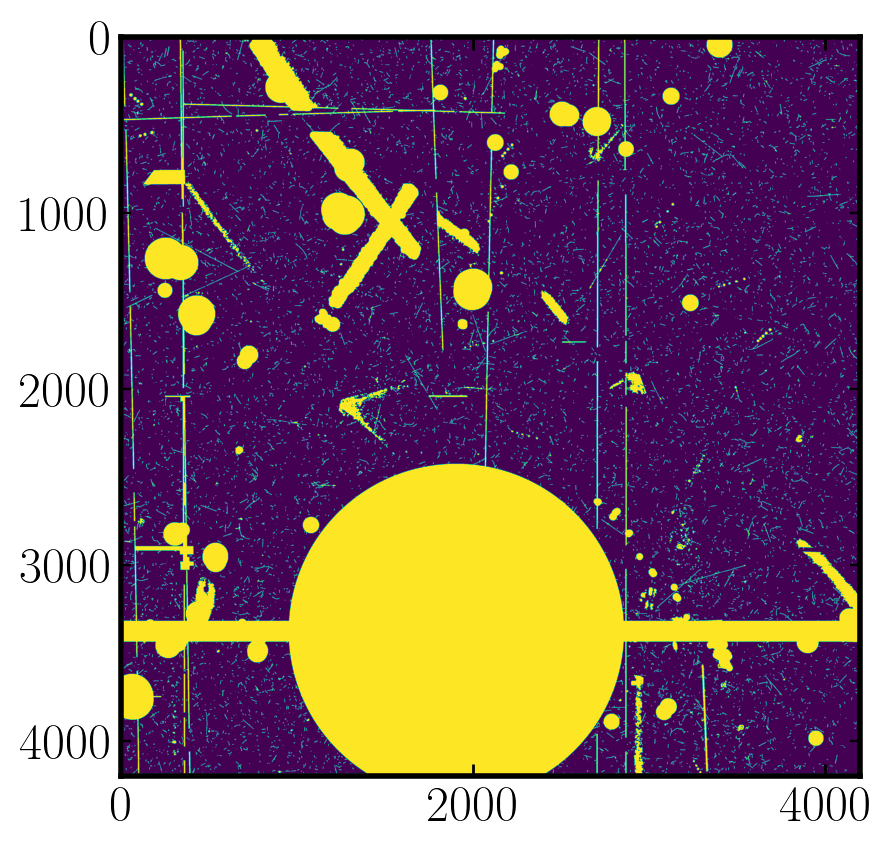

In [5]:
ii = 17
s23b_calexp = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_calexp/"
s23b_mask = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_mask/"
s23b_nimg = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_nImage/"
tract_id = 9720
patch_id = patch_ids[ii]
print(patch_id)
calexp_dir = f"{s23b_calexp}/{tract_id}/{patch_id}/i"
exp_fname = glob.glob(os.path.join(calexp_dir, "*.fits"))[0]
exposure = afwImage.ExposureF.readFits(exp_fname)
mask_dir = f"{s23b_mask}/{tract_id}/{patch_id}"
mask_fname = os.path.join(mask_dir, "mask2.fits")
bmask = fitsio.read(mask_fname)
nim_dir = f"{s23b_nimg}/{tract_id}/{patch_id}/i"
nim_fname = glob.glob(os.path.join(nim_dir, "*.fits"))[0]
nim = fitsio.read(nim_fname)
bmask = (bmask | (nim <= 2).astype(np.int16))
plt.close()
plt.imshow(bmask)
ii += 1

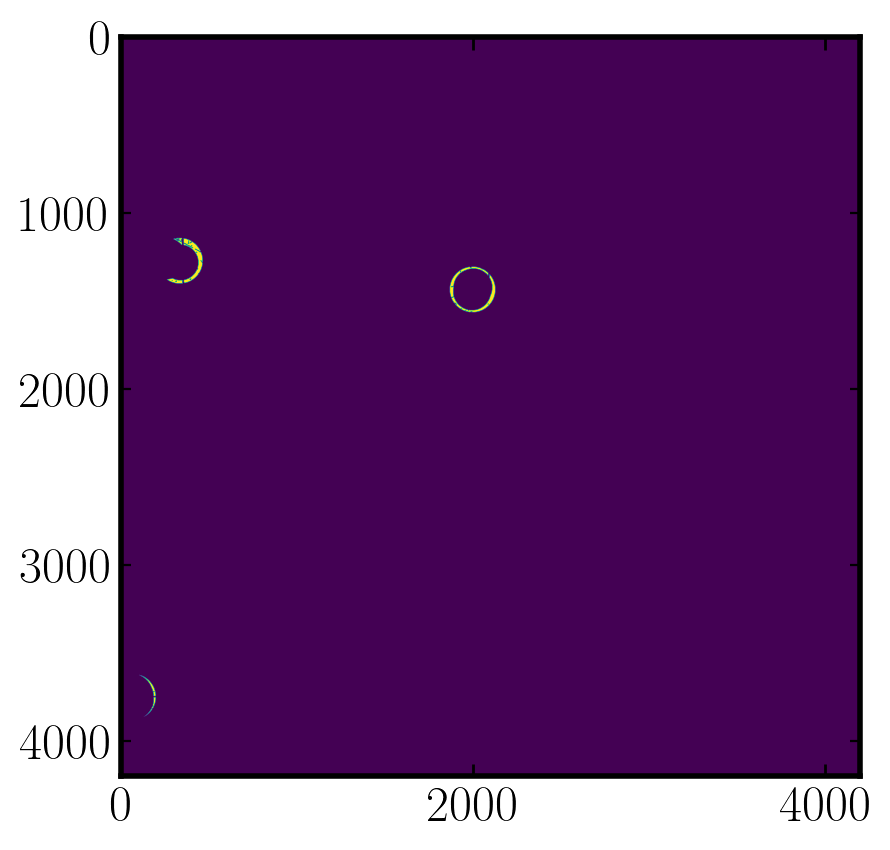

In [6]:
plt.close()
mask_fname = os.path.join(mask_dir, "mask3.fits")
bmask2 = fitsio.read(mask_fname)
bmask2 = (bmask2 | (nim <= 2).astype(np.int16))
plt.imshow(bmask2 - bmask)

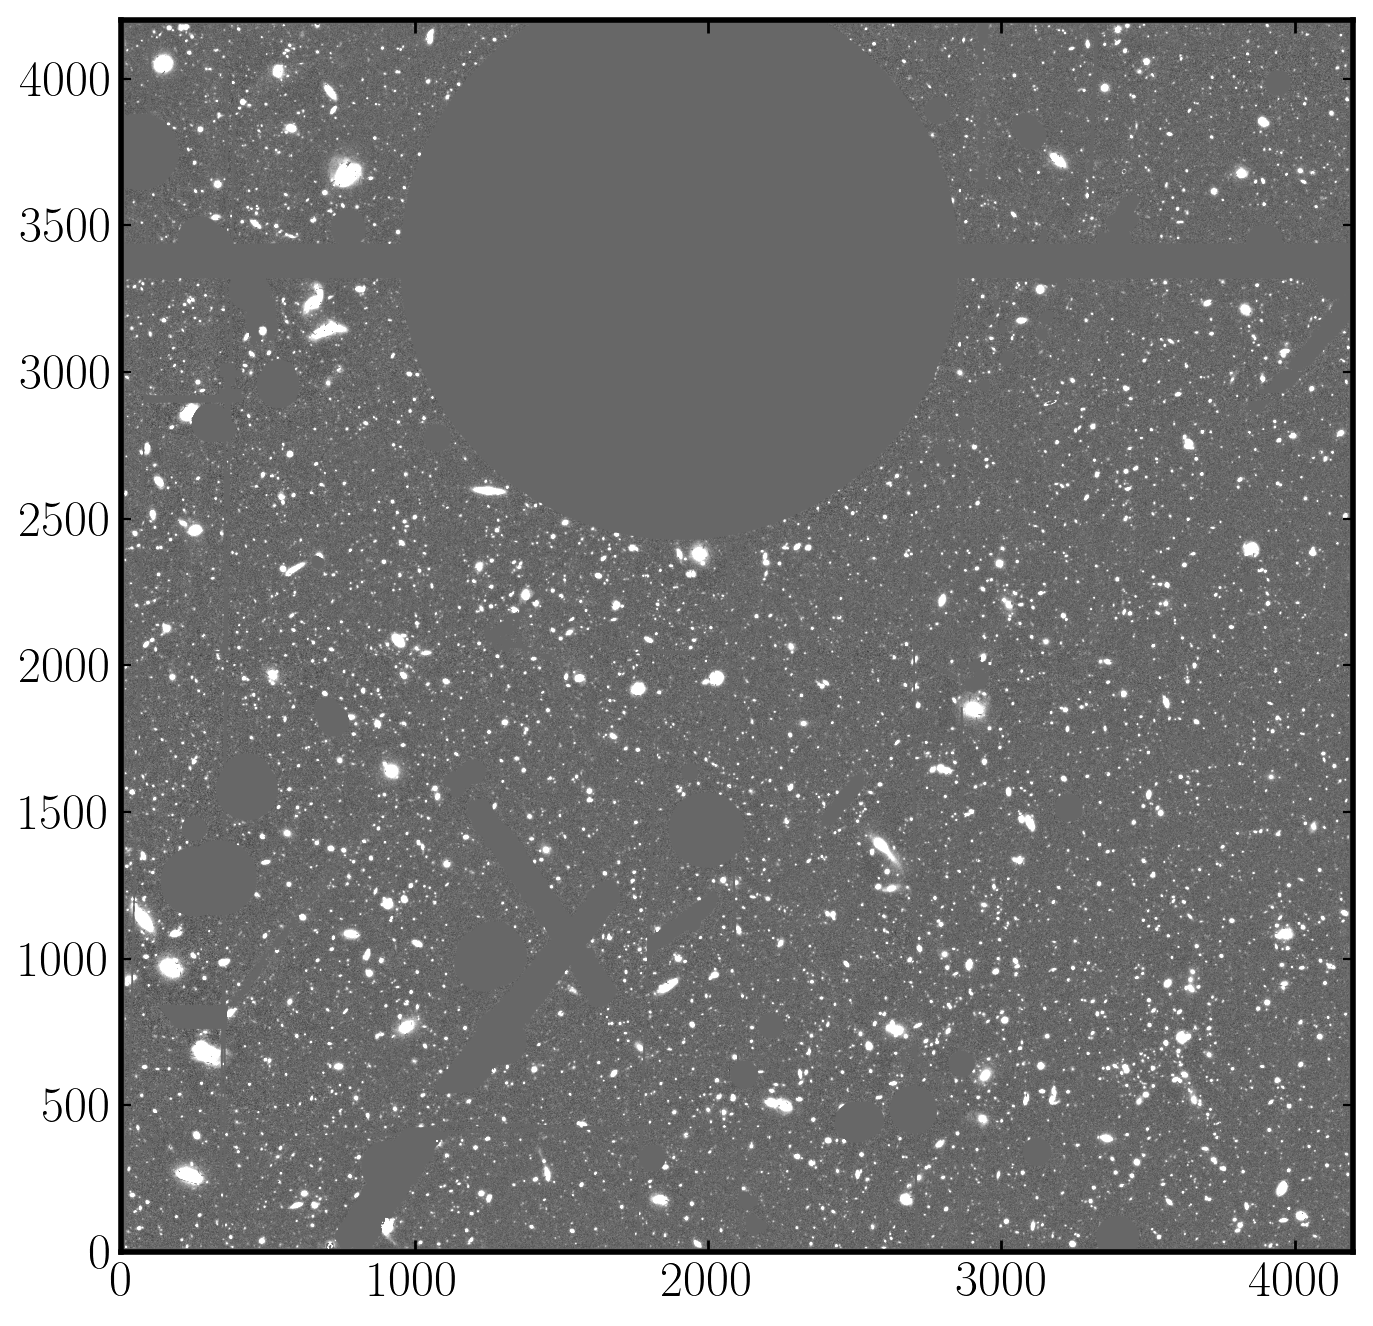

In [7]:
plt.close()
mask_fname = os.path.join(mask_dir, "mask3.fits")
bmask2 = fitsio.read(mask_fname)
bmask2 = (bmask2 | (nim <= 2).astype(np.int16))
interval = ZScaleInterval()
image = exposure.image.array* -1.0 * (bmask2 - 1)
vmin, vmax = interval.get_limits(image)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

In [13]:
# Set up the configuration
config = RingsSkyMapConfig()
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0 / 60  # degrees
config.pixelScale = 0.168  # arcsec/pixel
skymap = RingsSkyMap(config)

config = AnacalDetectPipeConfig()
config.anacal.force_size = False
config.anacal.num_epochs = 8
config.anacal.do_noise_bias_correction = True
config.anacal.validate_psf = False
task = AnacalDetectPipe(config=config)

def read_files(tract_id, patch_id):
    calexp_dir = f"{os.environ['s23b_calexp']}/{tract_id}/{patch_id}/i"
    exp_fname = glob.glob(os.path.join(calexp_dir, "*.fits"))[0]
    exposure = afwImage.ExposureF.readFits(exp_fname)
    mask_dir = f"{os.environ['s23b_mask']}/{tract_id}/{patch_id}"
    mask_fname = os.path.join(mask_dir, "mask3.fits")
    bmask = fitsio.read(mask_fname)
    nim_dir = f"{os.environ['s23b_nimg']}/{tract_id}/{patch_id}/i"
    nim_fname = glob.glob(os.path.join(nim_dir, "*.fits"))[0]
    bmask = (bmask | (fitsio.read(nim_fname) <=2).astype(np.int16))
    corr_fname = f"{os.environ['s23b_noisecorr']}/{tract_id}.fits"
    noise_corr = fitsio.read(corr_fname)
    return {
        "exposure": exposure,
        "mask": bmask,
        "noise_corr": noise_corr,
    }


patch_info = skymap[tract_id][patch_id]
wcs = patch_info.getWcs()
bbox = patch_info.getOuterBBox()

res = read_files(tract_id, patch_id)
seed = (tract_id * 1000 + patch_id) * 5
data = task.anacal.prepare_data(
    exposure=res["exposure"],
    seed=seed,
    noise_corr=res["noise_corr"],
    detection=None,
    band=None,
    skyMap=skymap,
    tract=tract_id,
    patch=patch_id,
    mask_array=res["mask"],
)
catalog = task.anacal.run(**data)

In [ ]:
plt.close()
image = data["gal_array"]
bb = exposure.getBBox()
x1 = catalog["x1"] / 0.168 - bb.beginX
x2 = catalog["x2"] / 0.168 - bb.beginY

# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.scatter(x1, x2, s=5, c='red', edgecolors='black', linewidths=0.5, alpha=0.7)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()